# Visualização de dados de uma conversa num grupo de WhatsApp

Para fazer isso, usam-se estas bibliotecas: chatminer, pandas, numpy, bs4, e matplotlib, e spacy. A função de cada uma será descrita nas próximas células.

Em primeiro lugar, importamos a função <i>whatsapp parser</i> e lemos o arquivo.txt com ela.

In [1]:
from chatminer.chatparsers import WhatsAppParser

parser = WhatsAppParser('zap.txt')

c:\Users\mateu\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
05.02.2023 19:33:21 INFO     
            Depending on the platform, the message format in chat logs might not be
            standardized accross devices/versions/localization and might change over
            time. Please report issues including your message format via GitHub.
            
05.02.2023 19:33:21 INFO     Initialized parser.
05.02.2023 19:33:21 INFO     Starting reading raw messages into memory...
05.02.2023 19:33:22 INFO     Finished reading 39999 raw messages into memory.
05.02.2023 19:33:22 INFO     Inferred DMY format for date.


De que tipo é o objeto parser?

In [2]:
type(parser)

chatminer.chatparsers.WhatsAppParser

Agora, vou convertê-la em DataFrame, objeto da biblioteca pandas, com a qual vou visualizar os dados com o matplotlib.

In [3]:
parser.parse_file_into_df()

05.02.2023 19:33:35 INFO     Starting parsing raw messages into dataframe...
100%|██████████| 39999/39999 [00:06<00:00, 6636.80it/s]
05.02.2023 19:33:41 INFO     Finished parsing raw messages into dataframe.


O objeto parser agora tem um dataframe. Para acessá-lo, basta por .df

In [4]:
import pandas
df = parser.df
df

,datetime,author,message,weekday,hour,words,letters
0,2023-01-16 16:25:00,Lucas Muniz,txt?,Monday,16,1,4
1,2023-01-16 15:44:00,Mateus,Descobri um módulo maneiro em Python que compi...,Monday,15,11,69
2,2023-01-16 15:43:00,Mateus,Quem tem as mensagens mais antigas do grupo?,Monday,15,8,44
3,2023-01-16 15:43:00,Mateus,Rapaziada,Monday,15,1,9
4,2023-01-16 09:02:00,Pablo,Intankavel,Monday,9,1,10
...,...,...,...,...,...,...,...
39994,2022-02-07 14:25:00,Lucas Muniz,vou esperar o jogo da discórdia pra ver se dá ...,Monday,14,20,88
39995,2022-02-07 14:23:00,Inayara,Dg se lascou com o voto ontem,Monday,14,7,29
39996,2022-02-07 14:23:00,Pablo,????,Monday,14,1,4
39997,2022-02-07 14:23:00,Inayara,Tb acho q não,Monday,14,4,13


Definitivamente, não quero mensagens do aplicativo atrapalhando nossos dados

In [5]:
df = df[(df.author != 'System') & (df.message != "<Arquivo de mídia oculto>") & (df.message != "Mensagem apagada")]
df

,datetime,author,message,weekday,hour,words,letters
0,2023-01-16 16:25:00,Lucas Muniz,txt?,Monday,16,1,4
1,2023-01-16 15:44:00,Mateus,Descobri um módulo maneiro em Python que compi...,Monday,15,11,69
2,2023-01-16 15:43:00,Mateus,Quem tem as mensagens mais antigas do grupo?,Monday,15,8,44
3,2023-01-16 15:43:00,Mateus,Rapaziada,Monday,15,1,9
4,2023-01-16 09:02:00,Pablo,Intankavel,Monday,9,1,10
...,...,...,...,...,...,...,...
39994,2022-02-07 14:25:00,Lucas Muniz,vou esperar o jogo da discórdia pra ver se dá ...,Monday,14,20,88
39995,2022-02-07 14:23:00,Inayara,Dg se lascou com o voto ontem,Monday,14,7,29
39996,2022-02-07 14:23:00,Pablo,????,Monday,14,1,4
39997,2022-02-07 14:23:00,Inayara,Tb acho q não,Monday,14,4,13


Agora, vou colecionar as <i>stopwords</i>, ou seja, artigos, pronomes demonstativos e preposições, basicamente. Vou fazer isso com o módulo nltk

In [6]:
from nltk.corpus import stopwords
s_words = stopwords.words('portuguese') + \
    ['pra', 'n', 'q', 'https', 'ai', 'aí', 'porra', 'caralho', 'merda', 'puta', 'cu']
# adicionei estas palavras para não poluir o wordcloud,
# mas, para refletir bem a conversa do grupo, o ideal seria não
# censurar os palavrões
s_words[0:10]


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

## Visualização

Vou usar estes módulos:
Counter, matplotlib e vis

### Histograma

Primeiramente, vou pegar a média de mensagens por pessoas e atribuir uma cor para os membros e para a média

In [10]:
from collections import Counter
import matplotlib.pyplot as plt
author_counts = Counter(df.author)
author_counts['Média'] = len(df.message) / len(author_counts.keys())
author_counts = {k: v for k, v in sorted(author_counts.items(), key=lambda item: item[1], reverse=True)} # ordenando o dicionário
author_counts

{'Pablo': 8810,
 'Nathanael': 8685,
 'Lucas Muniz': 7783,
 'Média': 3746.5,
 'Mateus': 3495,
 'Leila': 3000,
 'Gabilan': 2618,
 'Inayara': 1632,
 'Bolinha': 859,
 'Nathan': 573,
 'Isabelly': 10}

Vou, além disso, dar cores à barra de média e aos usuários (azul para estes e vermelho para aquela) numa tupla

In [17]:
colors = tuple(['red' if x == 'Média' else 'blue' for x in author_counts.keys()])

Por fim, vou gerar um bar plot com a frequência de mensagens por autor.

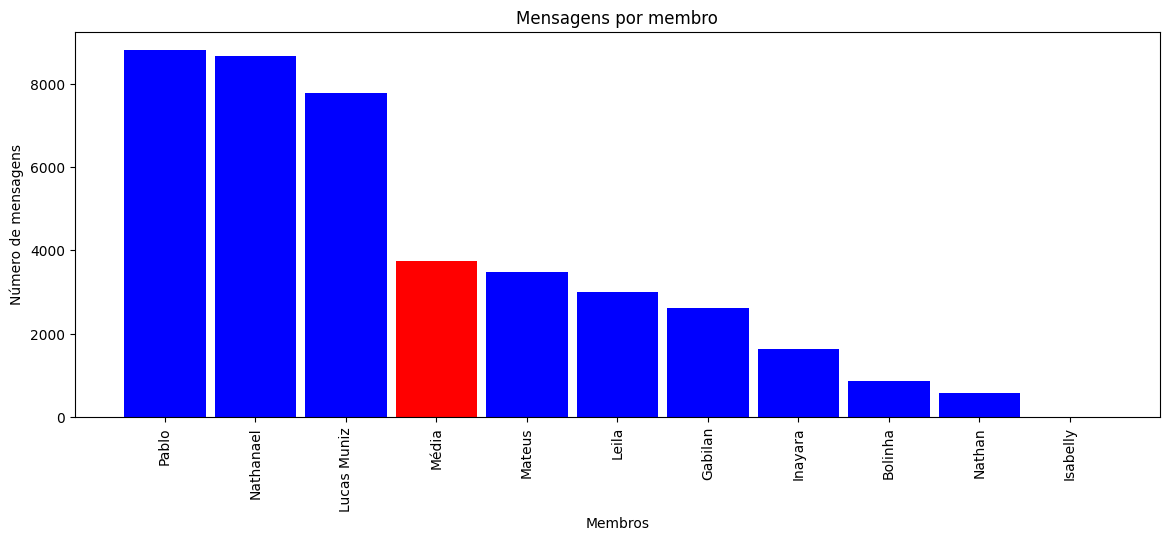

In [20]:
fig = plt.figure(figsize = (14, 5))
plt.bar(list(author_counts.keys()), author_counts.values(), width=0.9, color=colors)
plt.xlabel("Membros")
plt.ylabel("Número de mensagens")
plt.title("Mensagens por membro")
plt.xticks(range(len(author_counts.keys())), author_counts.keys(), rotation='vertical')
plt.show()

### Histograma da quantidade de palavras por mensagem

Para os histogramas, eu resolvi remover copypastas. Fiz isso supondo que qualquer mensagem com mais de 50 palavras são desse tipo, mas, se seu grupo não costuma ter esse tipo de coisa, fica ao seu critétio alterar ou não.

In [25]:
df[df.words == df.words.max()] # obviamente uma copypasta

,datetime,author,message,weekday,hour,words,letters
311,2023-01-10 20:31:00,Bolinha,"*S.O.S.*🇧🇷🇧🇷🇧🇷 *Janeiro, 09, 2023* Governo c...",Tuesday,20,986,6007


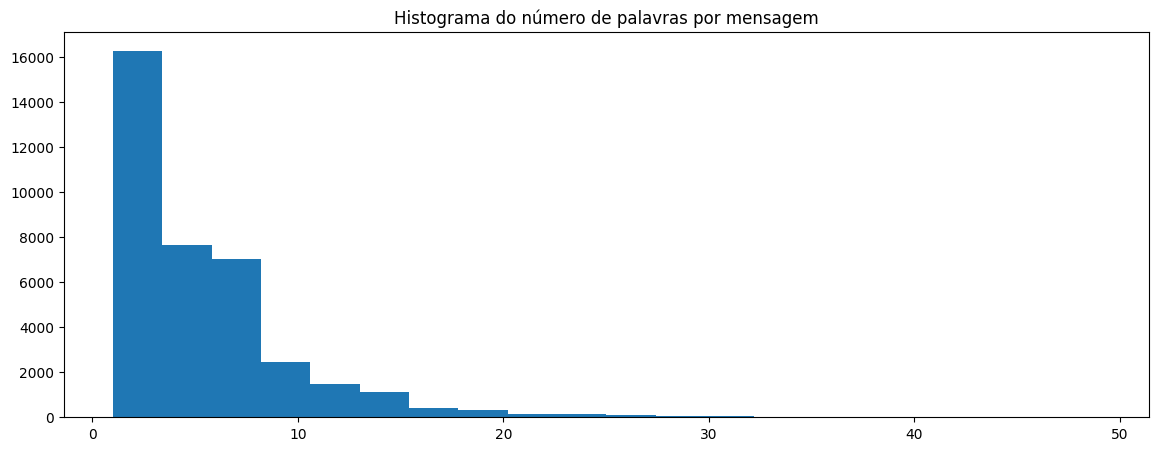

In [32]:
df_hist_words = df[df.words < 50]
fig = plt.figure(figsize = (14, 5))
plt.title("Histograma do número de palavras por mensagem")
plt.hist(df_hist_words.words, bins = 20)
plt.show()

### Barplot da quantidade de palavras por mensagem de cada membro

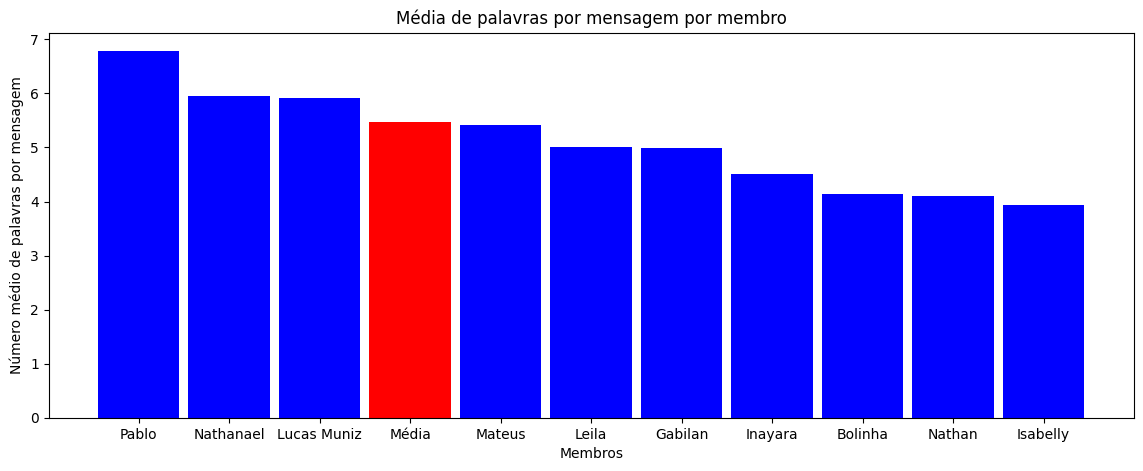

In [25]:
author_mean_messages = {}
authors = list(author_counts.keys())
for author in authors:
    if author == 'Média':
        author_mean_messages[author] = sum(df.words) / len(df.message)
    else:
        author_mean_messages[author] = df[df.author == author].words.sum() / author_counts[author]
author_mean_messages = {k: v for k, v in sorted(author_mean_messages.items(), key=lambda item: item[1], reverse=True)} # ordenando o dicionário
fig = plt.figure(figsize = (14, 5))
plt.bar(list(author_mean_messages.keys()), author_mean_messages.values(), width=0.9, color = colors)
plt.xlabel("Membros")
plt.ylabel("Número médio de palavras por mensagem")
plt.title("Média de palavras por mensagem por membro")
plt.xticks(range(len(author_counts.keys())), author_counts.keys())
plt.show()


### Heatmaps

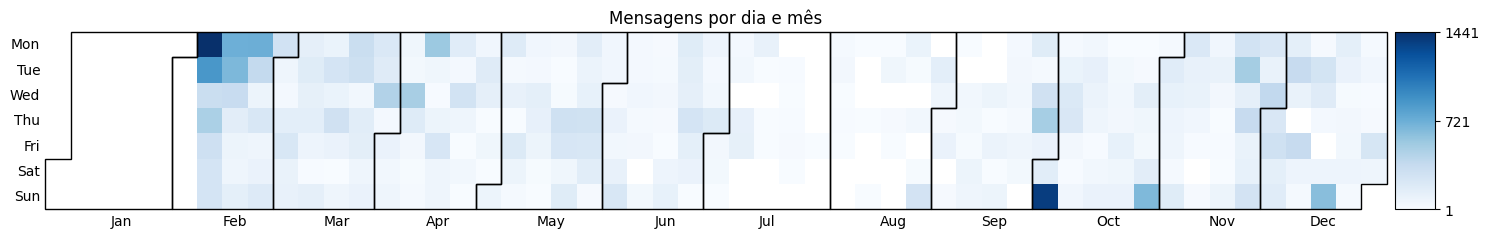

In [26]:
import chatminer.visualizations as vis
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.title("Mensagens por dia e mês")
ax = vis.calendar_heatmap(df, year=2022, linewidth=0, monthly_border=True, ax=ax)

### Sunburst

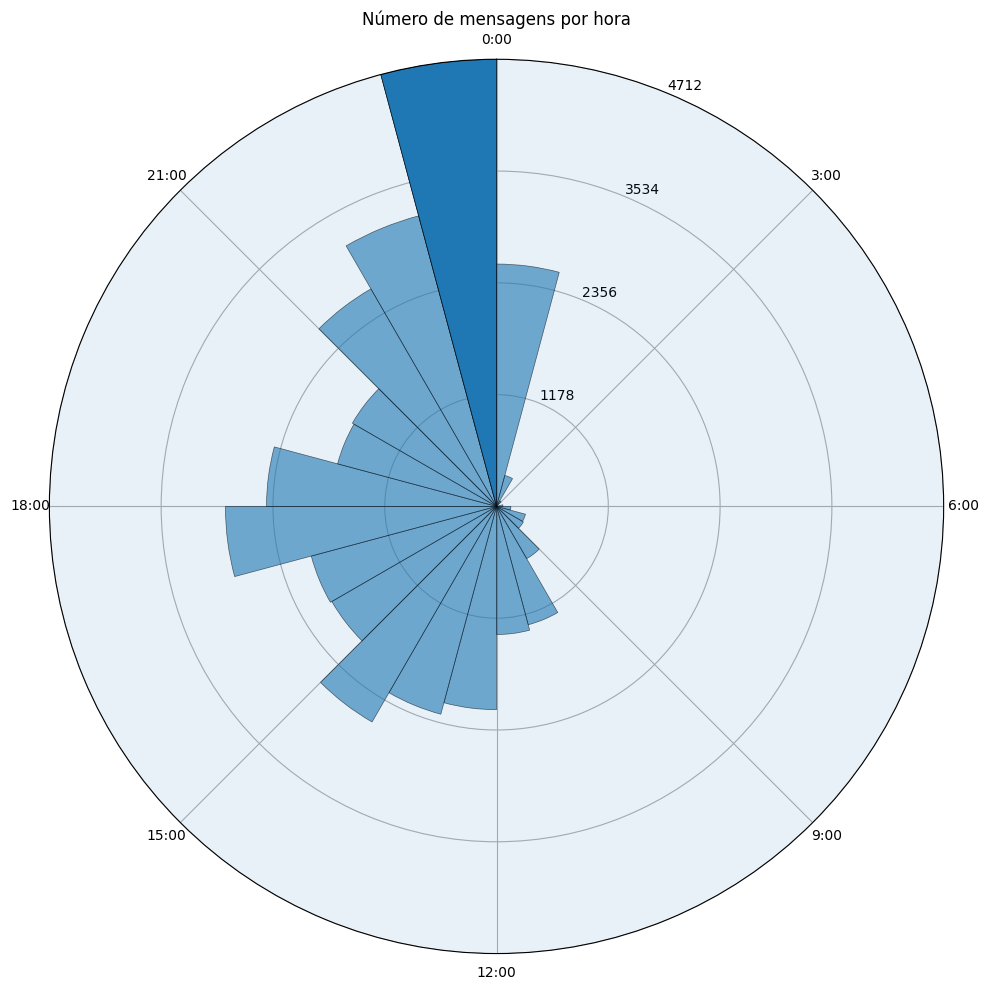

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': 'polar'})
plt.title("Número de mensagens por hora")
ax = vis.sunburst(df, highlight_max=True, isolines=[0.25, 0.5, 0.75, 1], ax=ax)

### Wordcloud

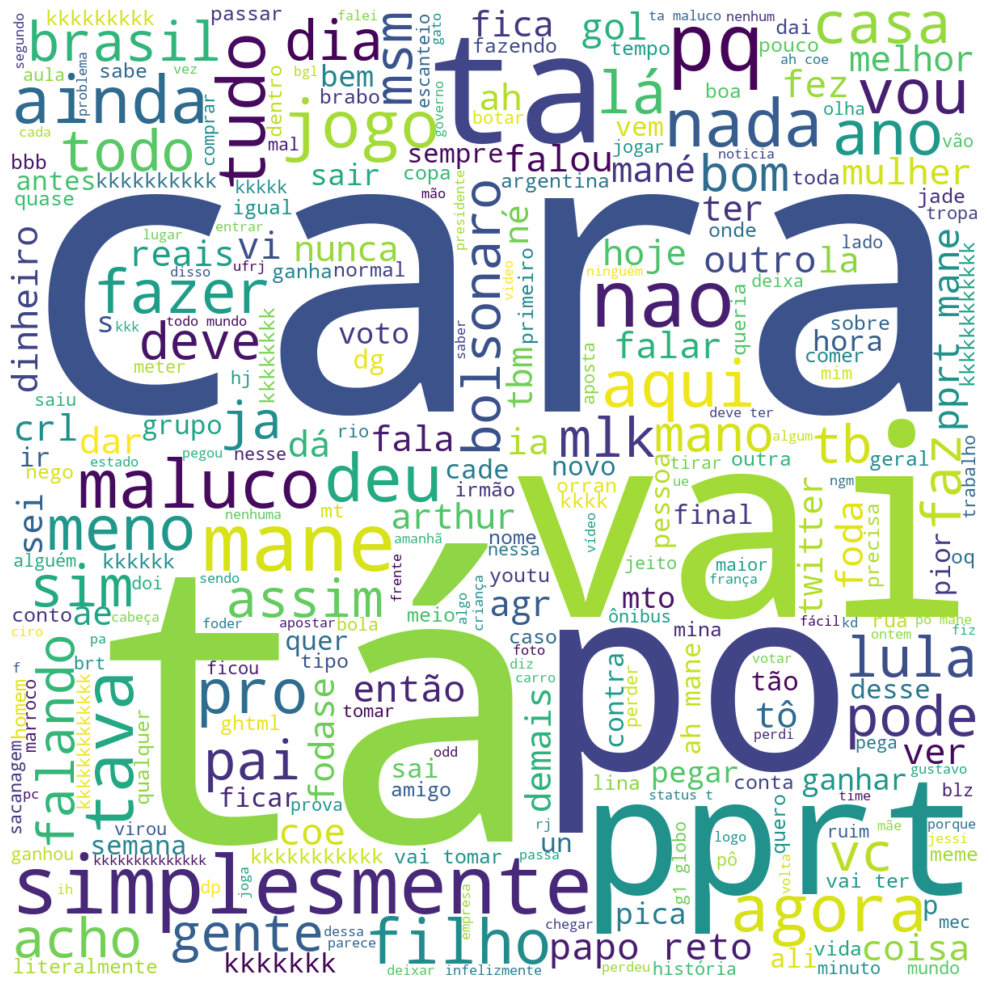

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))
kwargs={"background_color": "white", "width": 1200, "height": 1200, "max_words": 300}
ax = vis.wordcloud(df, ax=ax, stopwords=s_words, **kwargs)

### Radarchart

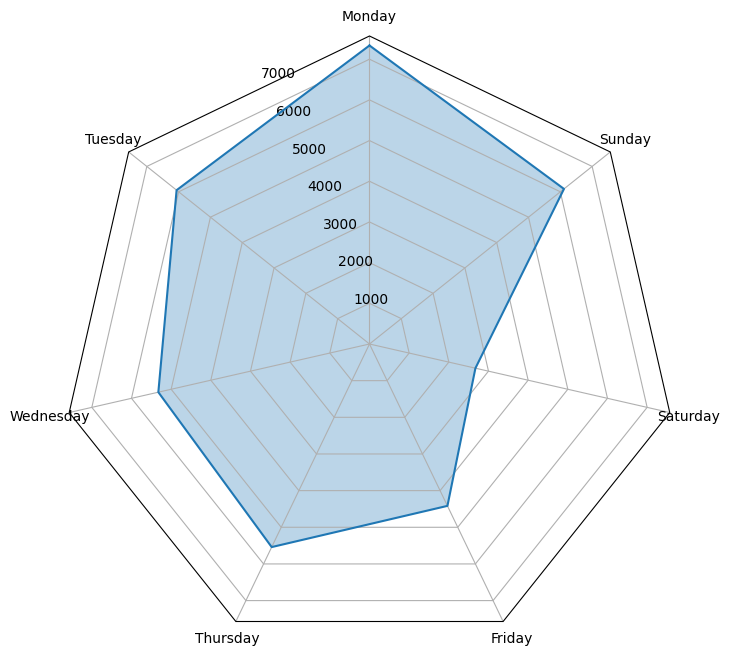

In [12]:
vis.radar_factory(7, frame="polygon")
fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'radar'})
ax = vis.radar(df, ax=ax)